# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers

%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 16

## Retrieve datasets

In [3]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
      with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')

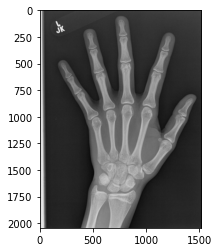

In [4]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

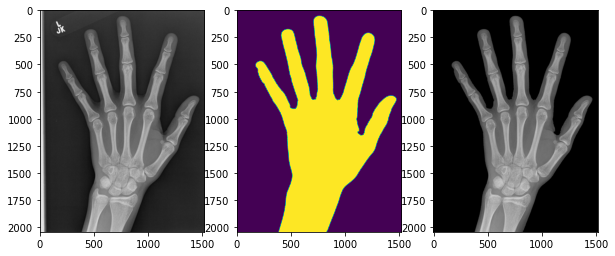

In [5]:
masks_path = 'boneage-training-dataset-masks'
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))

## Loading filenames

In [6]:
def load_filenames(file, path, path_p=None):
  if 'Test' in file:
    df = pd.read_excel(file)
  else:
    df = pd.read_csv(file)

  # Uniforming the dfs
  # reorder columns
  if 'train' in file:
    df = df[['id', 'male', 'boneage']]
  
  # rename columns
  df.set_axis(['image', 'gender(M/F)', 'boneage'], axis=1, inplace=True)

  # changing values for gender
  df['gender(M/F)'].replace({'M':0, 'F':1}, inplace=True) # for test set only
  df['gender(M/F)'].replace({True:0, False:1}, inplace=True) 

  # setting up the paths to get the images
  if path_p: # validation set images are divided in two folders
    mask_1 = df['image'] < 9727
    mask_2 = df['image'] >= 9727
    df.loc[mask_1, 'image'] = path + '/' + df.loc[mask_1, 'image'].astype(str) + '.png'
    df.loc[mask_2, 'image'] = path_p + '/' + df.loc[mask_2, 'image'].astype(str) + '.png'
  else: 
    df['image'] = path + '/' + df['image'].astype(str) + '.png'

  return df

In [7]:
# train_df = pd.read_csv('train.csv')
# validation_df = pd.read_csv(data_dirs[1] + '/Validation Dataset.csv')
# test_df = pd.read_excel(data_dirs[2] + '/Bone age ground truth.xlsx')
train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv',
                               val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx',
                         data_dirs[2] + '/Test Set Images')

In [8]:
display(train_df)
display(validation_df)
display(test_df)

,image,gender(M/F),boneage
0,boneage-training-dataset/1377.png,1,180
1,boneage-training-dataset/1378.png,1,12
2,boneage-training-dataset/1379.png,1,94
3,boneage-training-dataset/1380.png,0,120
4,boneage-training-dataset/1381.png,1,82
...,...,...,...
12606,boneage-training-dataset/15605.png,1,50
12607,boneage-training-dataset/15606.png,1,113
12608,boneage-training-dataset/15608.png,1,55
12609,boneage-training-dataset/15609.png,0,150


,image,gender(M/F),boneage
0,boneage-validation-dataset-1/1386.png,1,30
1,boneage-validation-dataset-1/1392.png,0,162
2,boneage-validation-dataset-1/1397.png,1,18
3,boneage-validation-dataset-1/1401.png,1,132
4,boneage-validation-dataset-1/1410.png,0,57
...,...,...,...
1420,boneage-validation-dataset-2/15592.png,1,42
1421,boneage-validation-dataset-2/15601.png,1,132
1422,boneage-validation-dataset-2/15607.png,0,186
1423,boneage-validation-dataset-2/15611.png,1,120


,image,gender(M/F),boneage
0,Bone Age Test Set/Test Set Images/4360.png,0,168.934249
1,Bone Age Test Set/Test Set Images/4361.png,0,169.652678
2,Bone Age Test Set/Test Set Images/4362.png,0,73.256112
3,Bone Age Test Set/Test Set Images/4363.png,0,152.862669
4,Bone Age Test Set/Test Set Images/4364.png,0,135.456954
...,...,...,...
195,Bone Age Test Set/Test Set Images/4555.png,1,133.486757
196,Bone Age Test Set/Test Set Images/4556.png,1,129.254493
197,Bone Age Test Set/Test Set Images/4557.png,1,167.685033
198,Bone Age Test Set/Test Set Images/4558.png,1,135.980312


### Create the datasets

**PS** *Bring this two functions below inside a .py file and import it*

In [9]:
def load_hand_image(img_name):
    num_row = 512
    num_col = 512

    if isinstance(img_name, bytes):
        img_name = img_name.decode()

    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')
    plt.imshow(img)

    return img

In [10]:
def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

In [11]:
def create_dataset(file_names, batch_size, shuffle, cache_file=None):
# def create_dataset(path, file_names, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_hand_image, [file_name], tf.float32))
    # py_func = lambda file_name: (tf.numpy_function(load_hand_image, [path + file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder.
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [12]:
batch_size = 32
train_dataset = create_dataset(train_df['image'],
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(validation_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

test_dataset = create_dataset(test_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='test_cache')

train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))
test_steps = int(np.ceil(test_df.shape[0] / batch_size))

## Data augmentation, Batching, Normalization : check LAB4 - ImageDataGenerator

In [13]:
# datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
#                              width_shift_range=4,  # randomly shift images horizontally
#                              height_shift_range=4,  # randomly shift images vertically 
#                              horizontal_flip=True,  # randomly flip images
#                              vertical_flip=True)  # randomly flip images
# datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
# datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

In [14]:
# # Use this function to fit the model with data augmentation

# # Fit the model on batches with real-time data augmentation:
# model.fit(datagen_train.flow_from_dataframe(train_df, x_col='paths', y_col='month', batch_size=batch_size, shuffle=True), 
#           validation_data=datagen_val.flow(validation_df, x_col='paths', y_col='month', batch_size=batch_size, shuffle=False),
#           epochs=100, 
#           steps_per_epoch=train_steps,
#           validation_steps=val_steps,
#           callbacks=[callback])

Otherwise use functions below

In [15]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [16]:
def random_crop(input_image):
  cropped_image = tf.image.random_crop(input_image, size=[2, IMG_SIZE, IMG_SIZE, 3])

  return cropped_image

In [17]:
@tf.function()
def random_jitter(input_image):
  # Resizing to 286x286
  input_image = resize(input_image, 286, 286)

  # Random cropping back to 256x256
  input_image = random_crop(input_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)

  return input_image

In [18]:
def load_image_train(image_file):
  input_image = load(image_file)
  input_image = random_jitter(input_image)
  input_image = normalize(input_image)

  return input_image, real_image

In [19]:
def load_image_test(image_file):
  input_image = load(image_file)
  input_image = resize(input_image, IMG_SIZE, IMG_SIZE)
  input_image = normalize(input_image)

  return input_image

## Create the Model for prediction

In this case we substitute the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

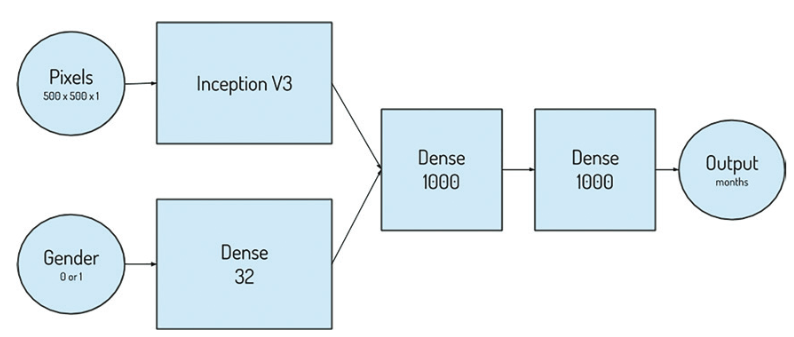

In [20]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py

In [21]:
from inc_v4 import *
from tensorflow.keras.applications.inception_v3 import InceptionV3

def Bone_Age():
  
  X_input = Input([512, 512, 1]) # we should use grayscale images
  gen_input = Input([1])
  
  # Inception block
  X = Inceptionv4(X_input, include_top=False) # 14 x 14 x 1536
  # to use it as a model check Github

  X = AveragePooling2D((2, 2))(X) # 7 x 7 x 1536 (or 2048 for v3)
  X = Flatten()(X)

  # Dense block (gender)
  gen = Dense(32, activation='relu')(gen_input)

  # Concatenation
  X = tf.concat(values=[X, gen], axis=1)

  # First Dense block
  X = Dense(1000, activation='relu')(X)

  # Second Dense block
  X = Dense(1000, activation='relu')(X)

  # Fully connected layer
  X = Dense(1)(X)

  return tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name='Bone_Age')

In [22]:
model = Bone_Age()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae", "accuracy"])
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Let's try to implement a simpler model

### Let's see if everything works correctly with the first 200 images

First apply the masks

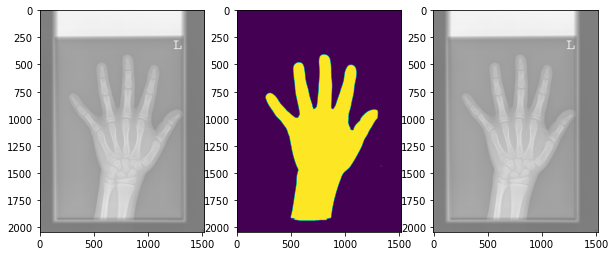

In [34]:
a = cv2.imread(train_df.loc[2, 'image'])
b = cv2.imread(path + masks_path + '1379.png', 0)
# plt.imshow(cv2.bitwise_and(a, a, mask = b))

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(a)
ax[1].imshow(b)
ax[2].imshow(cv2.bitwise_and(a, a, mask=b))
# WHY IS NOT WORKING ????

In [38]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
!mkdir /content/boneage_training_masked

In [ ]:
masks_path = 'boneage-training-dataset-masks/'
masked_path = 'boneage-training-masked/'
for index in range(200):
  im_path = train_df.loc[index, 'image']
  im_name = im_path.split('/')[1]
  image = cv2.imread(im_path)
  mask_im = cv2.imread(path + '/' + masks_path + im_name, 0)
  masked_im = cv2.bitwise_and(image, image, mask=mask_im)
  cv2.imwrite(masked_path + im_name, masked_im)

# When it will work the images should be overwritten in the same place from
# where they come since it's the path written inside the 'image' column of the dfs

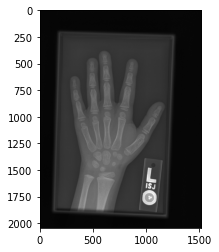

In [37]:
plt.imshow(cv2.imread(masked_path + '1604.png')) ### NOT WORKING

In [ ]:
# TRY TO CONVERT THE ABOVE FUNCTION IN A MAP FUNCTION
mask_func = lambda image: cv2.imwrite(masked_path + image.split('/')[1], cv2.bitwise_and(
    cv2.imread(image), cv2.imread(image), 
    mask=cv2.imread(path + '/' + masks_path + image.split('/')[1], 0)))
temp = train_df.copy()
temp.loc[:, 'image'] = temp.loc[:, 'image'].map(mask_func)

Divide the dataset

In [33]:
# first let's try with all masked images (both for training and testing)
x_train = train_df.loc[:150, ['image', 'gender(M/F)']]
y_train = train_df.loc[:150, 'boneage']
x_val = train_df.loc[150:180, ['image', 'gender(M/F)']]
y_val = train_df.loc[150:180, 'boneage']
x_test = train_df.loc[180:, ['image', 'gender(M/F)']]
y_test = train_df.loc[180:, 'boneage']

In [30]:
# Create a callback for early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [ ]:
# Fit the model on batches with real-time data augmentation:
x_train = train_df[:180]
y_train = train_df
model.fit(train_df[:180], 
          validation_data=, epochs=100, 
          steps_per_epoch=train_steps,
          validation_steps=test_steps,
          callbacks=[callback])